In [1]:
# a notebook to run the cpox simulation and compare to experiment

# based on this guy? uncertainty_estimator/nam29_presentation/cpox_Pt/plot_cpox.ipynb

In [2]:
import cantera as ct
import numpy as np
import scipy.signal
import os

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# # Rh111
# # mech_yaml = './cpox_pt_20241020/chem_annotated-gas.yaml'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_emily/chem_annotated-gas.yaml'
# # mech_yaml = './cpox_rh_20241112/handpicked/chem_annotated-gas.yaml'
# rh_data = '/home/moon/uncertainty_estimator/cpox_pt/horn_data/rh_profiles_smooth.csv'
# df = pd.read_csv(rh_data)


# Pt111
# mech_yaml = '/home/moon/uncertainty_estimator/nam29_presentation/cpox_Pt/chem_annotated.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated.yaml'

pt_data = '/home/moon/uncertainty_estimator/cpox_pt/horn_data/pt_profiles_smooth.csv'
df = pd.read_csv(pt_data)

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])


# gas, _ = ct.import_phases(mech_yaml, ["gas", "surface1"])
# surf = ct.Interface(mech_yaml, 'surface1')  # new way


# surf = ct.Interface(mech_yaml,'surface1')
# gas = surf.adjacent['gas']

print(f'This mechanism contains {gas.n_species} gas species and {surf.n_species} surface species')
print(f'This mechanism contains {gas.n_reactions} gas reactions and {surf.n_reactions} surface reactions')

This mechanism contains 24 gas species and 21 surface species
This mechanism contains 62 gas reactions and 145 surface reactions


In [4]:
def get_i_thing(ref_composition, phase):
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False
    return -1

In [5]:
# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_C2H4 = get_i_thing({'C': 2.0, 'H': 4.0}, gas)
i_x = get_i_thing({'X': 1.0}, surf)

In [6]:
# Make the colors consistent between all mechanism
np.random.seed(400)
color_dict = {
    "{'X': 1.0}": '#1f77b4',
    "{'O': 1.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 1.0, 'O': 1.0, 'X': 1.0}": '#d62728',
    "{'H': 1.0, 'N': 1.0, 'X': 1.0}": '#9467bd',
    "{'N': 1.0, 'O': 1.0, 'X': 2.0}": '#8c564b',
    "{'H': 3.0, 'N': 1.0, 'X': 1.0}": '#e377c2',
    "{'H': 2.0, 'N': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'N': 2.0, 'X': 2.0}": '#bcbd22',
    "{'N': 1.0, 'X': 1.0}": '#17becf',
    "{'H': 2.0, 'X': 1.0}": '#1f77b4',
    "{'N': 2.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 2.0, 'O': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 2.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#8c564b',
    "{'H': 3.0, 'N': 2.0, 'O': 1.0, 'X': 1.0}": '#9467bd',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 2.0}": '#e377c2',
    "{'N': 1.0, 'O': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#bcbd22',
    "{'H': 2.0, 'N': 2.0, 'X': 1.0}": '#17becf'
}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color(species):
    try:
        return color_dict[str(species.composition)]
    except KeyError:
        return colors[int(np.random.random() * len(colors))]

In [7]:
#######################################################################
# Input Parameters
#######################################################################

# unit conversion factors to SI
mm = 0.001
cm = 0.01
ms = mm
minute = 60.0

t_in = 700  # K - in the paper, it was ~698.15K at the start of the cat surface and ~373.15 for the gas inlet temp
t_cat = t_in
length = 70 * mm  # Reactor length- m
diam = 16.5*mm  # Reactor diameter - in m
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube) in m^2
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000  # I made this up, in m-1. 4500 is lowest that "work" for all base
flow_rate = 4.7  # slpm
flow_rate = flow_rate*.001/60  # m^3/s
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate/area  # m/s
# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 7001
# NReactors = 101

on_catalyst = 1000  # catalyst length 10mm, but it doesn't say where.  let's guess at 1 cm?
off_catalyst = 2000
dt = 1.0

reactor_len = length/(NReactors-1)
rvol = area * reactor_len * porosity
# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

In [8]:
T = t_in

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

# def monolithFull(gas, surf, T):
x_CH4 = 0.296
x_O2 = 0.147
x_Ar = 1.0 - x_CH4 - x_O2

X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
print(X)
gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
mass_flow_rate = flow_rate * gas.density_mass
gas.TPX = T, ct.one_atm, X
surf.TP = T, ct.one_atm

initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_x] = 1.0
surf.coverages = initial_coverages

# surf.coverages = f'{surf.species_names[i_x]}: 1.0'

# create a new reactor
r = ct.IdealGasReactor(gas)
r.volume = rvol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, master=m, K=1e-5)
# v = ct.PressureController(r, downstream, primary=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
# sim.rtol = 1.0e-11
# sim.atol = 1.0e-20

# sim.rtol = 1.0e-10
# sim.atol = 1.0e-20

gas_names = gas.species_names
surf_names = surf.species_names
gas_out = []
surf_out = []
dist_array = []
T_array = []

surf.set_multiplier(0.0)  # no surface reactions until the gauze
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = r.thermo.TDY
    upstream.syncState()
    if n > on_catalyst:
        surf.set_multiplier(1.0)
    if n > off_catalyst:
        surf.set_multiplier(0.0)
        
#     N_OFF = 10
#     for i in range(N_OFF):
#         surf.set_multiplier(0.0, surf.n_reactions - i - 1)
        
#     N_OFF_GAS = 30
#     for i in range(N_OFF_GAS):
#         gas.set_multiplier(0.0, surf.n_reactions - i - 1)
    
    sim.reinitialize()
    sim.advance_to_steady_state()

#     sim.advance(1e12)
#     sim.advance_to_steady_state(max_steps=100000)
    dist = n * reactor_len * 1.0e3  # distance in mm
    dist_array.append(dist)
    T_array.append(surf.T)
    # print "mass_flow_rate", mass_flow_rate,  v.mdot(sim.time), "kg/s"
    kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
    gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute
    surf_out.append(surf.X.copy())

gas_out = np.array(gas_out)
surf_out = np.array(surf_out)
gas_names = np.array(gas_names)
surf_names = np.array(surf_names)
data_out = gas_out, surf_out, gas_names, surf_names, dist_array, T_array
    # return data_out

CH4(2): 0.296, O2(3): 0.147, Ar: 0.5569999999999999


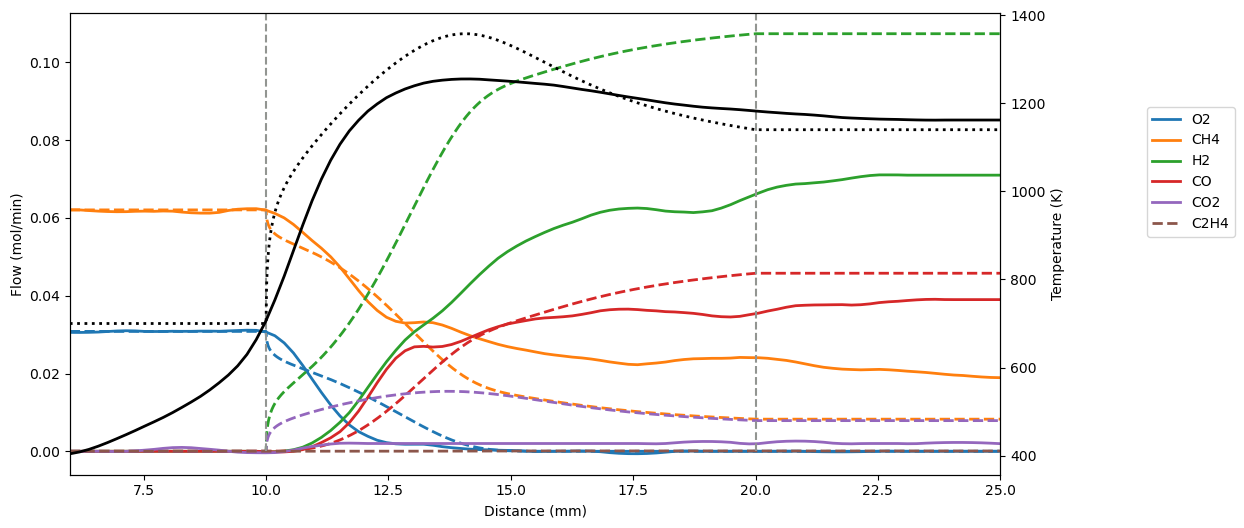

In [9]:
# Plot the result
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linewidth1 = 2.0
linewidth2 = 2.0

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(df['Distance (mm)'].values, df['O2 (mol/min)'].values, label='O2', color=colors[0], linewidth=linewidth1)
plt.plot(dist_array, gas_out[:, i_O2], label='_no_label', color=colors[0], linestyle='--', linewidth=linewidth2)

plt.plot(df['Distance (mm)'].values, df['CH4 (mol/min)'].values, label='CH4', color=colors[1], linewidth=linewidth1)
plt.plot(dist_array, gas_out[:, i_CH4], label='_no_label', color=colors[1], linestyle='--', linewidth=linewidth2)


plt.plot(df['Distance (mm)'].values, df['H2 (mol/min)'].values, label='H2', color=colors[2], linewidth=linewidth1)
plt.plot(dist_array, gas_out[:, i_H2], label='_no_label', color=colors[2], linestyle='--', linewidth=linewidth2)

plt.plot(df['Distance (mm)'].values, df['CO (mol/min)'].values, label='CO', color=colors[3], linewidth=linewidth1)
plt.plot(dist_array, gas_out[:, i_CO], label='_no_label', color=colors[3], linestyle='--', linewidth=linewidth2)

plt.plot(df['Distance (mm)'].values, df['CO2 (mol/min)'].values, label='CO2', color=colors[4], linewidth=linewidth1)
plt.plot(dist_array, gas_out[:, i_CO2], label='_no_label', color=colors[4], linestyle='--', linewidth=linewidth2)


plt.plot(dist_array, gas_out[:, i_C2H4], label='C2H4', color=colors[5], linestyle='--', linewidth=linewidth2)


ax1 = plt.gca()
ylim = ax1.get_ylim()
# Mark the catalyst extent
plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.ylim(ylim)

ax2 = ax1.twinx()
ax2.plot(df['Distance (mm)'].values, df['Temperature (K)'].values, label='Temperature', color='k', linewidth=linewidth1)
ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
ax2.set_ylabel('Temperature (K)')

ax1.set_xlim([6, 25])
ax1.set_xlabel('Distance (mm)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.15, 0.5))
